In [95]:
import os
import pandas as pd

from pinecone import Pinecone

PINECONE_INDEX_NAME="fineweb10bt-768-arctic-m-v2-weborganizer-full"
PINECONE_API_KEY="pcsk_2JLk5N_HWFfTetUnDpNrFCXiGqqG3MszTXWuvXRftPwd7GN6FKFmae3eD8zoNhXMUgkJgF"
pc = Pinecone(api_key=PINECONE_API_KEY)

# To get the unique host for an index, 
# see https://docs.pinecone.io/guides/data/target-an-index
index = pc.Index(PINECONE_INDEX_NAME)

In [1]:
from rag import pinecone_utils

/opt/homebrew/Caskroom/miniconda/base/envs/liverag/lib/python3.12/site-packages/pinecone/data/index.py:1: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [91]:
from rag import embedding

In [97]:
from multiprocessing.pool import ThreadPool

# ─── BATCH-QUERY SUPPORT ──────────────────────────────────────────────────
def batch_query_pinecone(
    vectors: list[str],
    top_k: int = 5,
    namespaces: str | list[str] = "default",
    n_parallel: int = 10,
) -> list[dict]:
    """
    Query Pinecone for each query in parallel.
    Returns a list of result dicts.
    """
    if namespaces == "default":
        namespaces = pinecone_utils.list_namespaces()
    elif isinstance(namespaces, str):
        namespaces = [namespaces]

    # Precompute all embeddings
    def _worker(vec):
        return index.query_namespaces(
            vector=vec,
            top_k=top_k,
            namespaces=namespaces,
            metric="cosine",
            include_metadata=True,
            show_progress=False,
            include_values=True,
        )

    with ThreadPool(n_parallel) as pool:
        return pool.map(_worker, vectors)


In [99]:
df = pd.read_json("/Users/saksornr/Code/hackathon/liverag-dev/dota-rag/data/eval_collection/Snowflake100+Routing+Prune20+Rerank10/testset-50q-result.jsonl", lines=True)
embeddings = embedding.batch_embed_queries(df['question'].tolist())
print("done emb!")
df['search'] = batch_query_pinecone(embeddings, top_k=5, n_parallel=8)
print("done search!")

done emb!
done search!


In [105]:
def get_id(x):
    return [i['id'].split("::")[0].replace("doc-", "") for i in x['matches']]

def id_hit(x):
    doc_id = x['doc_id']
    return any([doc_id == i for i in x['search_id']])

def id_hit2(x):
    doc_id = x['doc_id']
    return any([doc_id == i for i in x['passage_id']])

df = df.dropna()
df['search_id'] = df['search'].map(get_id)
df['passage_id'] = df['passages'].map(lambda x: [i['doc_IDs'][0] for i in x])
df['is_search_hit'] = df.apply(id_hit, axis=1)
df['is_passage_hit'] = df.apply(id_hit2, axis=1)
df.to_csv('compare_search.csv', index=False)

In [121]:
import glob
result_jsonl_list = glob.glob("data/eval_collection/*/*result.jsonl")
result_jsonl_list.sort(reverse=True)
eval_jsonl_list = glob.glob("data/eval_collection/*/*eval.jsonl")
eval_jsonl_list.sort(reverse=True)
eval_jsonl_list

['data/eval_collection/Snowflake500+Routing+Prune100+Rerank20/testset-50q-eval.jsonl',
 'data/eval_collection/Snowflake50+Routing+Prune20+Rerank10/testset-50q-eval.jsonl',
 'data/eval_collection/Snowflake100+Routing+VRSD+Prune20+Rerank10/testset-50q-eval.jsonl',
 'data/eval_collection/Snowflake100+Routing+Prune20+Rerank10_v2/testset-50q-eval.jsonl',
 'data/eval_collection/Snowflake100+Routing+Prune20+Rerank10/testset-50q-eval.jsonl',
 'data/eval_collection/Snowflake100+Routing+Prune20+Rerank10+no_refine/testset-50q-eval.jsonl',
 'data/eval_collection/Snowflake10+Routing/testset-50q-eval.jsonl']

In [140]:
sumdf_list = []
for k, v in (zip(result_jsonl_list,eval_jsonl_list)):
    ex = pd.read_json(k, lines=True)
    ev = pd.read_json(v, lines=True)
    m = pd.concat([ex, ev], axis=1)
    collection_name = k.split("/")[-2]
    df = m.dropna(subset="question").reset_index(drop=True)
    # cols = ['id', 'doc_id', 'question_category', 'question_category_desc',
    #    'user_category', 'user_category_desc', 'question', 'gold', 'answer',
    #    'idx', 'faithfulness', 'relevance',
    #    'faithfulness_correct', 'relevance_correct']
    # m[cols].to_csv(f'data/eval_collection/{collection_name}/merge-for-eda.csv', index=False)
    # df = df.iloc[:27]
    # df['relevance_correct'] = (df['relevance'] >= 1).astype(int)
    df['passage_id'] = df['passages'].map(lambda x: [i['doc_IDs'][0] for i in x])
    df['is_passage_hit'] = df.apply(id_hit2, axis=1)

    sumdf = {
        # 'faithfulness_correct': (df['faithfulness'].dropna() >= 1).mean(),
        # 'relevance_correct': (df['relevance'].dropna() >= 1).mean(),
        'faithfulness_correct': (df['faithfulness_correct']).mean(),
        'relevance_correct': (df['relevance_correct']).mean(),
        "collection_name": k.split("/")[-2],
        "hit-rate": df['is_passage_hit'].sum() / len(df)
    }
    sumdf_list.append(sumdf)
sumdf_list = pd.DataFrame(sumdf_list).set_index("collection_name")
sumdf_list = sumdf_list.sort_values("faithfulness_correct")

stat_df_list = pd.DataFrame(stat_df_list)
sumdf_list


,faithfulness_correct,relevance_correct,hit-rate
collection_name,,,
Snowflake10+Routing,0.562500,0.833333,0.367347
Snowflake500+Routing+Prune100+Rerank20,0.659574,0.797872,0.489796
Snowflake100+Routing+VRSD+Prune20+Rerank10,0.708333,0.833333,0.428571
Snowflake50+Routing+Prune20+Rerank10,0.729167,0.843750,0.428571
Snowflake100+Routing+Prune20+Rerank10_v2,0.765957,0.819149,0.428571
Snowflake100+Routing+Prune20+Rerank10,0.812500,0.812500,0.428571
Snowflake100+Routing+Prune20+Rerank10+no_refine,0.829787,0.872340,0.448980


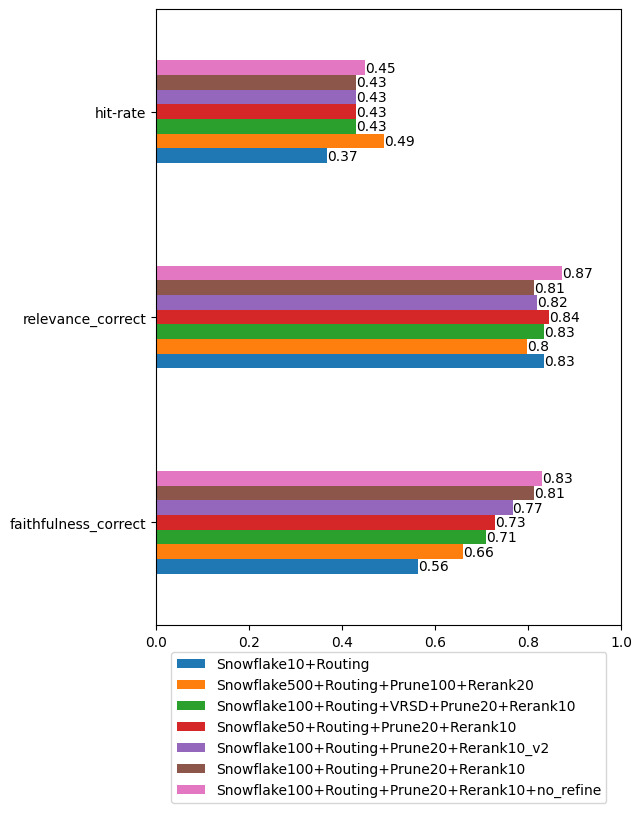

In [141]:
ax = sumdf_list.T.plot.barh(figsize=(6, 8))
for container in ax.containers:
    ax.bar_label(container, fmt="%.2g")

ax.set_xlim(0, 1)
ax.legend(loc="lower center", bbox_to_anchor=(0.5, -0.3))

In [120]:
df['is_search_hit'].sum() / len(df), df['is_passage_hit'].sum() / len(df)
# ฮธิบายว่าไม่ได้ rewrite อะไรเลย แค่ query ได้ hit rate มากกว่าแหะ ?

KeyError: 'is_search_hit'

In [77]:
any([True, False, False, False, False]
)

True

# TEST

In [47]:
query = "Can I use a drone to take pictures of Crazy Horse Memorial?"
r = pinecone_utils.query_pinecone(query, top_k=10)

In [57]:
print(r['matches'][0]['metadata']['text'])

In order to film or take photos at Crazy Horse Memorial®, both interior and exterior locations, for any commercial purposes, companies/individuals must first obtain written approval from ©Crazy Horse Memorial Foundation. As the Mountain, statues, museum items, and other exterior and interior items are copyrighted. Due to the high volume of requests for filming and photography at the Memorial, all requests must be submitted in writing at least 10 days prior to the shoot. - Written permission must be obtained in advance for taking photographs/filming in or around the Mountain, buildings, complex, and grounds. To allow time for questions and any necessary further clarification, please apply for permission in writing at least 10 working days before the scheduled date of photography. Photos for news reports and purely documentary purposes can usually be approved more quickly. - Where permission is granted, the applicant will receive written confirmation. - Use of drones /mini-copters is str

In [ ]:
print(r['matches'][0]['metadata']['text'])

In [12]:
stats = index.describe_index_stats()
ns = list(stats.get("namespaces", {}).keys())
ns

['Software',
 'Transportation',
 'Education & Jobs',
 'Fashion & Beauty',
 'Health',
 'Crime & Law',
 'Entertainment',
 'History',
 'Software Dev.',
 'Sports & Fitness',
 'Home & Hobbies',
 'Science & Tech.',
 'Finance & Business',
 'Food & Dining',
 'Games',
 'Hardware',
 'Politics',
 'Social Life',
 'Religion',
 'Industrial',
 'Literature',
 'Travel',
 'Adult',
 'Art & Design']

In [45]:
fe = index.fetch(ids=["doc-<urn:uuid:97aa5dda-1935-42ff-9a2c-1f6fb40f49e2>::chunk-1"], namespace='History')

{'date': '2022-05-26T17:34:10Z',
 'dump': 'CC-MAIN-2022-21',
 'file_path': 's3://commoncrawl/crawl-data/CC-MAIN-2022-21/segments/1652662619221.81/warc/CC-MAIN-20220526162749-20220526192749-00036.warc.gz',
 'format_classify': 'Legal Notices',
 'language': 'en',
 'language_score': 0.880591630935669,
 'text': 'In order to film or take photos at Crazy Horse Memorial®, both interior and exterior locations, for any commercial purposes, companies/individuals must first obtain written approval from ©Crazy Horse Memorial Foundation. As the Mountain, statues, museum items, and other exterior and interior items are copyrighted. Due to the high volume of requests for filming and photography at the Memorial, all requests must be submitted in writing at least 10 days prior to the shoot. - Written permission must be obtained in advance for taking photographs/filming in or around the Mountain, buildings, complex, and grounds. To allow time for questions and any necessary further clarification, please 

In [46]:
list(fe['vectors'].values())[0]['metadata']


{'date': '2022-05-26T17:34:10Z',
 'dump': 'CC-MAIN-2022-21',
 'file_path': 's3://commoncrawl/crawl-data/CC-MAIN-2022-21/segments/1652662619221.81/warc/CC-MAIN-20220526162749-20220526192749-00036.warc.gz',
 'format_classify': 'Legal Notices',
 'language': 'en',
 'language_score': 0.880591630935669,
 'text': 'In order to film or take photos at Crazy Horse Memorial®, both interior and exterior locations, for any commercial purposes, companies/individuals must first obtain written approval from ©Crazy Horse Memorial Foundation. As the Mountain, statues, museum items, and other exterior and interior items are copyrighted. Due to the high volume of requests for filming and photography at the Memorial, all requests must be submitted in writing at least 10 days prior to the shoot. - Written permission must be obtained in advance for taking photographs/filming in or around the Mountain, buildings, complex, and grounds. To allow time for questions and any necessary further clarification, please 